<a href="https://colab.research.google.com/github/antoniovfonseca/compare-deforestation-maps/blob/main/falseAlarm_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install openpyxl to read Excel files
!pip install openpyxl -q

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl

In [3]:
# Load the Excel file directly from GitHub
url = "https://raw.githubusercontent.com/antoniovfonseca/compare-deforestation-maps/main/prodesMapbiomas.xlsx"
df = pd.read_excel(url)

In [4]:
# Extract PRODES and MapBiomas years based on the coding rule
df["prodes_year"] = df["Value"] // 10000
df["mapbiomas_year"] = df["Value"] % 10000

In [5]:
def classify_row(row):
    if row["prodes_year"] == 0 and row["mapbiomas_year"] == 0:
        return "Correct Rejection"
    elif row["prodes_year"] == row["mapbiomas_year"]:
        return "Hit"
    elif row["prodes_year"] != 0 and row["mapbiomas_year"] == 0:
        return "Miss"
    else:
        return "False Alarm"

df["classification"] = df.apply(classify_row, axis=1)

In [6]:
def characterize_false_alarm(row):
    if row["classification"] != "False Alarm":
        return np.nan
    elif row["prodes_year"] == 0:
        return "Only MapBiomas"
    else:
        return row["mapbiomas_year"] - row["prodes_year"]

df["false_alarm_detail"] = df.apply(characterize_false_alarm, axis=1)


In [7]:
# Show the final DataFrame
df.head(20)  # You can change the number to show more rows

,Value,Count,prodes_year,mapbiomas_year,classification,false_alarm_detail
0,0,10720861602,0,0,Correct Rejection,NaN
1,2008,9129284,0,2008,False Alarm,Only MapBiomas
2,2009,5551766,0,2009,False Alarm,Only MapBiomas
3,2010,4670382,0,2010,False Alarm,Only MapBiomas
4,2011,4618504,0,2011,False Alarm,Only MapBiomas
5,2012,4028942,0,2012,False Alarm,Only MapBiomas
6,2013,4620024,0,2013,False Alarm,Only MapBiomas
7,2014,4096307,0,2014,False Alarm,Only MapBiomas
8,2015,4517393,0,2015,False Alarm,Only MapBiomas
9,2016,5333721,0,2016,False Alarm,Only MapBiomas


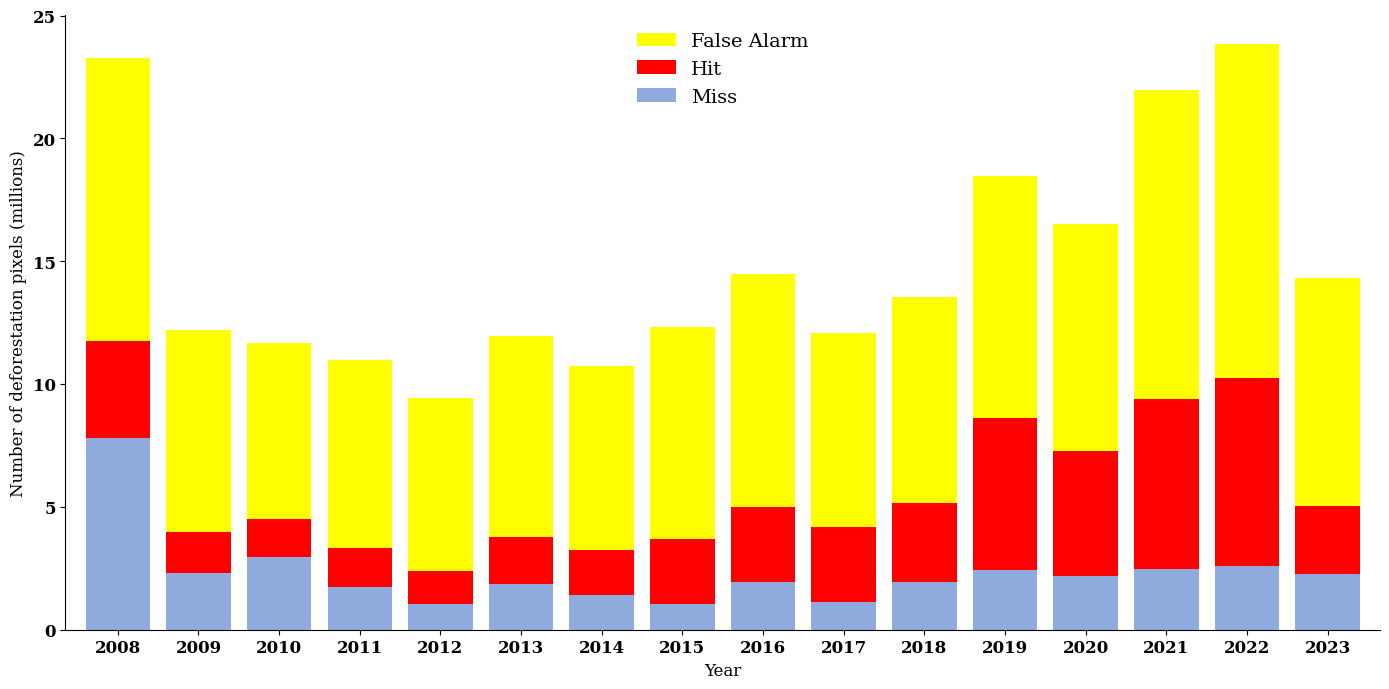

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pandas as pd

# Set Times New Roman (serif) as the global font
mpl.rcParams['font.family'] = 'serif'

# Define custom colors for each category
colors = {
    "Miss": "#8FAADC",
    "Hit": "#FF0000",
    "False Alarm": "#FFFF00"
}

# 1) “Miss”: sum counts by PRODES year, excluding zeros
miss = (
    df[(df['classification'] == 'Miss') & (df['prodes_year'] != 0)]
      .groupby('prodes_year')['Count']
      .sum()
      .rename('Miss')
)

# 2) “Hit”: sum counts by MapBiomas year
hit = (
    df[df['classification'] == 'Hit']
      .groupby('mapbiomas_year')['Count']
      .sum()
      .rename('Hit')
)

# 3) “False Alarm”: combine all false alarms, sum by MapBiomas year
false_alarm = (
    df[df['classification'] == 'False Alarm']
      .groupby('mapbiomas_year')['Count']
      .sum()
      .rename('False Alarm')
)

# Concatenate the three series, fill missing with zero, convert to int, and sort by year
stacked = (
    pd.concat([miss, hit, false_alarm], axis=1)
      .fillna(0)
      .astype(int)
      .sort_index()
)

# # Plot a stacked bar chart with the defined colors
# ax = stacked.plot(
#     kind='bar',
#     stacked=True,
#     figsize=(14, 7),
#     width=0.8,
#     color=[colors[col] for col in stacked.columns]
# )

# # Style the x- and y-axis labels and ticks
# plt.xticks(rotation=0, fontweight='bold', fontsize=12)
# plt.yticks(rotation=0, fontweight='bold', fontsize=12)
# plt.xlabel("Year", fontsize=12)
# plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)

# # Format y-axis values in millions
# ax.yaxis.set_major_formatter(
#     mtick.FuncFormatter(lambda x, _: f"{x*1e-6:.0f}")
# )

# # Clean up the legend and remove top/right spines
# plt.legend(frameon=False, fontsize=14)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.show()


ax = stacked.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    width=0.8,
    color=[colors[c] for c in stacked.columns],
    legend=False
)

# pega handles e labels originais
handles, labels = ax.get_legend_handles_labels()

# ordem top-to-bottom que resulta na leitura bottom-to-top desejada
top_down = ['False Alarm', 'Hit', 'Miss']

# mapeia cada rótulo ao seu handle
new_handles = [handles[labels.index(lbl)] for lbl in top_down]

# plota legenda uma única vez, na ordem especificada
ax.legend(
    new_handles,
    top_down,
    frameon=False,
    fontsize=14
)

# configurações de eixo e formatação continuam iguais
plt.xticks(rotation=0, fontweight='bold', fontsize=12)
plt.yticks(rotation=0, fontweight='bold', fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x*1e-6:.0f}")
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

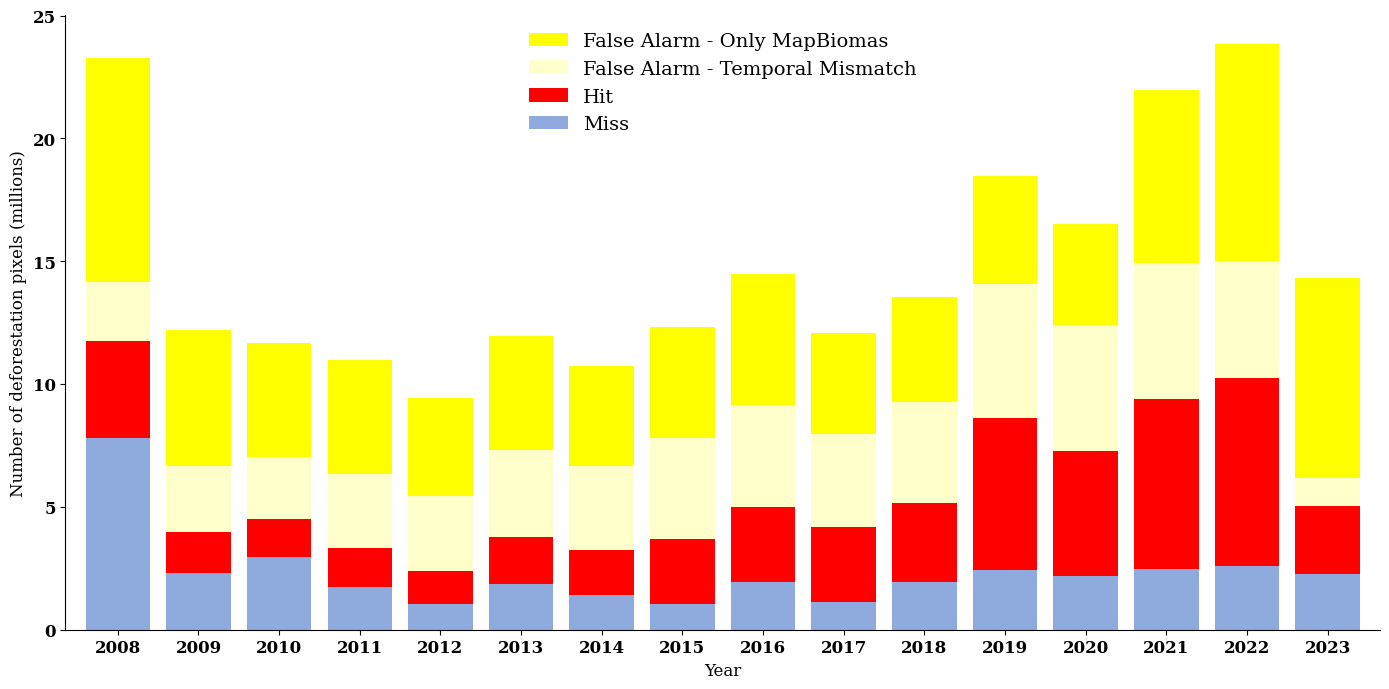

In [53]:
# Set Times New Roman as the global font
mpl.rcParams['font.family'] = 'serif'

# Define custom colors for each category
colors = {
    "Miss": "#8FAADC",
    "Hit": "#FF0000",
    "False Alarm - Temporal Mismatch": "#FFFFCC",
    "False Alarm - Only MapBiomas": "#FFFF00",
}

# Filter and group data
miss = df[(df['classification'] == 'Miss') & (df['prodes_year'] != 0)]
miss_grouped = miss.groupby('prodes_year')['Count'].sum()

hit = df[df['classification'] == 'Hit'].groupby('mapbiomas_year')['Count'].sum()

fa_only = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] == 0)].groupby('mapbiomas_year')['Count'].sum()
fa_diff = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] != 0)].groupby('mapbiomas_year')['Count'].sum()

# Combine all classes in a single DataFrame
stacked = pd.concat([
    miss_grouped.rename("Miss"),
    hit.rename("Hit"),
    fa_diff.rename("False Alarm - Temporal Mismatch"),
    fa_only.rename("False Alarm - Only MapBiomas"),
], axis=1).fillna(0).astype(int)

stacked = stacked.sort_index()

# # Plot with custom colors
# stacked[[
#     "Miss",
#     "Hit",
#     "False Alarm - Temporal Mismatch",
#     "False Alarm - Only MapBiomas"
#     ]].plot(
#     kind="bar",
#     stacked=True,
#     figsize=(14, 7),
#     width=0.8,
#     color=[
#         colors["Miss"],
#         colors["Hit"],
#         colors["False Alarm - Temporal Mismatch"],
#         colors["False Alarm - Only MapBiomas"]
#     ]
# )

# # plt.title("Pixel Classification per Year", fontsize=14)
# plt.xticks(
#     rotation=0,
#     fontweight='bold',
#     fontsize=12
#            )
# plt.yticks(
#     rotation=0,
#     fontweight='bold',
#     fontsize=12
#            )
# plt.xlabel("Year", fontsize=12)
# plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)
# plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}'))
# plt.legend(frameon=False,
#            title=None,
#            fontsize=14)
# # Remove all outer frame lines
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.show()
# Plot with custom colors in the order you want the legend
# Plot with custom colors in the order that puts “Only MapBiomas” above “Temporal Mismatch”
# Plot with custom colors in the order that puts “Only MapBiomas” above “Temporal Mismatch”
# 1) plota as barras na ordem natural de stacked.columns, sem legenda automática
# plot mantendo a ordem natural de stacked.columns
# 1) plota as barras na ordem natural de stacked.columns
ax = stacked.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    width=0.8,
    color=[colors[c] for c in stacked.columns],
    legend=False
)

# pega handles e labels originais
handles, labels = ax.get_legend_handles_labels()

# ordem top-to-bottom que resulta na leitura bottom-to-top desejada
top_down = ['False Alarm - Only MapBiomas','False Alarm - Temporal Mismatch','Hit', 'Miss', ]

# mapeia cada rótulo ao seu handle
new_handles = [handles[labels.index(lbl)] for lbl in top_down]

# plota legenda uma única vez, na ordem especificada
ax.legend(
    new_handles,
    top_down,
    frameon=False,
    fontsize=14
)

# configurações de eixo e formatação continuam iguais
plt.xticks(rotation=0, fontweight='bold', fontsize=12)
plt.yticks(rotation=0, fontweight='bold', fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x*1e-6:.0f}")
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()



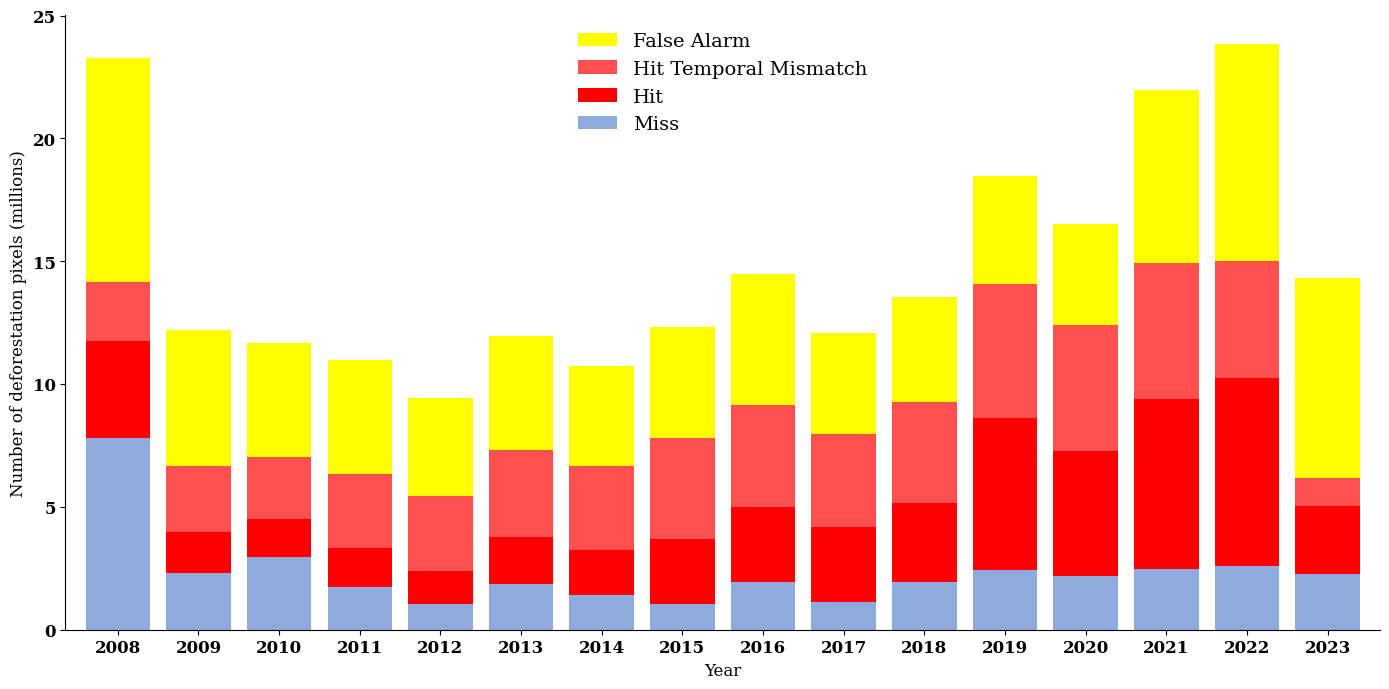

In [49]:
# Set Times New Roman (serif) as the global font
mpl.rcParams['font.family'] = 'serif'

# Define custom colors for each category
colors = {
    "Miss": "#8FAADC",
    "Hit": "#FF0000",
    "Hit Temporal Mismatch": "#ff5050",
    "False Alarm": "#FFFF00"
}

# Count “Miss” pixels by PRODES year (exclude zeros)
miss = (
    df[(df['classification'] == 'Miss') & (df['prodes_year'] != 0)]
      .groupby('prodes_year')['Count']
      .sum()
      .rename('Miss')
)

# Count “Hit” pixels by MapBiomas year
hit = (
    df[df['classification'] == 'Hit']
      .groupby('mapbiomas_year')['Count']
      .sum()
      .rename('Hit')
)

# Count “Hit Temporal Mismatch” by MapBiomas year (originally false alarms with PRODES year ≠ 0)
hit_mismatch = (
    df[(df['classification'] == 'False Alarm') & (df['prodes_year'] != 0)]
      .groupby('mapbiomas_year')['Count']
      .sum()
      .rename('Hit Temporal Mismatch')
)

# Count “False Alarm ” by MapBiomas year (PRODES year = 0)
fa_only = (
    df[(df['classification'] == 'False Alarm') & (df['prodes_year'] == 0)]
      .groupby('mapbiomas_year')['Count']
      .sum()
      .rename('False Alarm')
)

# Combine all categories into a single DataFrame, fill missing values with zero, convert to int, and sort by year
stacked = (
    pd.concat([miss, hit, hit_mismatch, fa_only], axis=1)
      .fillna(0)
      .astype(int)
      .sort_index()
)

# Plot a stacked bar chart with the defined colors and specified column order
# ax = stacked[["Miss", "Hit", "Hit Temporal Mismatch", "False Alarm"]].plot(
#     kind='bar',
#     stacked=True,
#     figsize=(14, 7),
#     width=0.8,
#     color=[colors[col] for col in ["Miss", "Hit", "Hit Temporal Mismatch", "False Alarm"]]
# )

# plot without legend
# ax = stacked.plot(
#     kind='bar',
#     stacked=True,
#     figsize=(14, 7),
#     width=0.8,
#     color=[colors[c] for c in stacked.columns],
#     legend=False
# )

# # get current handles and labels
# handles, labels = ax.get_legend_handles_labels()

# # define top-to-bottom legend order so bottom-to-top reads False Alarm → Hit → Hit Temporal Mismatch → Miss
# top_down = ['Miss', 'Hit', 'Hit Temporal Mismatch', 'False Alarm']

# # map to handles
# new_handles = [handles[labels.index(lbl)] for lbl in top_down]

# # draw legend
# ax.legend(new_handles, top_down, frameon=False, fontsize=14)


# # Style the x- and y-axis ticks and labels
# plt.xticks(rotation=0, fontweight='bold', fontsize=12)
# plt.yticks(rotation=0, fontweight='bold', fontsize=12)
# plt.xlabel("Year", fontsize=12)
# plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)

# # Format y-axis values in millions
# ax.yaxis.set_major_formatter(
#     mtick.FuncFormatter(lambda x, _: f"{x*1e-6:.0f}")
# )

# # Style the legend and remove top/right spines for a cleaner look
# plt.legend(frameon=False, fontsize=14)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.tight_layout()
# plt.show()

ax = stacked.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    width=0.8,
    color=[colors[c] for c in stacked.columns],
    legend=False
)

# pega handles e labels originais
handles, labels = ax.get_legend_handles_labels()

# ordem top-to-bottom que resulta na leitura bottom-to-top desejada
top_down = ['False Alarm','Hit Temporal Mismatch', 'Hit', 'Miss']

# mapeia cada rótulo ao seu handle
new_handles = [handles[labels.index(lbl)] for lbl in top_down]

# plota legenda uma única vez, na ordem especificada
ax.legend(
    new_handles,
    top_down,
    frameon=False,
    fontsize=14
)

# configurações de eixo e formatação continuam iguais
plt.xticks(rotation=0, fontweight='bold', fontsize=12)
plt.yticks(rotation=0, fontweight='bold', fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x*1e-6:.0f}")
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

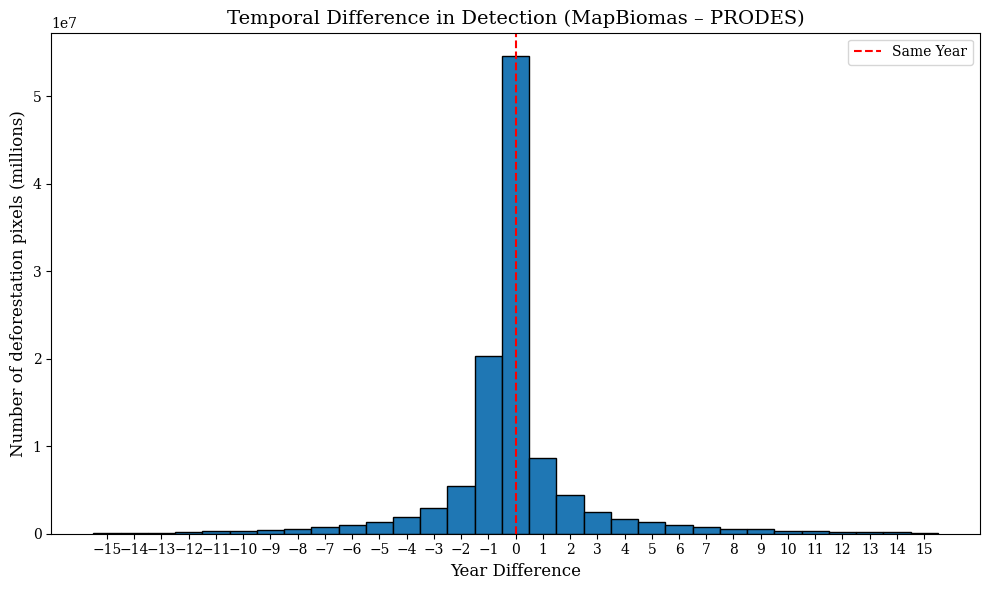

In [75]:
# Set Times New Roman (serif) as the global font
mpl.rcParams['font.family'] = 'serif'

# 1) Filter false alarms where PRODES also detected, but in a different year
mismatch = df[(df['classification'] == 'False Alarm') & (df['prodes_year'] != 0)]

# 2) Build an array of year‐difference values for mismatches, repeated by pixel count
mismatch_diffs = np.repeat(
    mismatch['false_alarm_detail'].astype(int).values,
    mismatch['Count'].values
)

# 3) Filter “hits” (same‐year detections)
hits = df[df['classification'] == 'Hit']

# 4) Build an array of zeros for hits (year‐difference = 0), repeated by pixel count
hit_diffs = np.zeros(hits['Count'].sum(), dtype=int)

# 5) Combine hits and mismatches into one array
diff_values = np.concatenate([hit_diffs, mismatch_diffs])

# create integer‐centered bins
bins = np.arange(diff_values.min() - 0.5,
                 diff_values.max() + 1.5,
                 1)


ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x*1e-6:.0f}")
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figure(figsize=(10, 6))
plt.hist(diff_values,
         bins=bins,
         edgecolor='black')

# put ticks exactly at the integers
plt.xticks(np.arange(diff_values.min(), diff_values.max() + 1, 1))

plt.title('Temporal Difference in Detection (MapBiomas – PRODES)', fontsize=14)
plt.xlabel('Year Difference', fontsize=12)
plt.ylabel("Number of deforestation pixels (millions)", fontsize=12)

# vertical line at 0
plt.axvline(0, color='red', linestyle='--', label='Same Year')
plt.legend()


plt.tight_layout()
plt.show()
